# CNN

We start by importing the libraries.

In [1]:
# Import libraries
import numpy as np
import time
import matplotlib
import matplotlib.image as mpimg
import pandas as pd
from torch import optim
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
import nltk
nltk.download('wordnet')
from sklearn.feature_extraction.text import TfidfTransformer
from nltk.corpus import stopwords
from nltk import word_tokenize
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer
nltk.download('stopwords')
nltk.download('punkt')
from sklearn.feature_extraction.text import CountVectorizer
import re
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.metrics import classification_report
from tensorflow.keras.preprocessing.text import Tokenizer
import spacy
from sklearn.preprocessing import OneHotEncoder
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, LSTM, Embedding, Dropout, SpatialDropout1D, Conv1D, MaxPooling1D, GRU, BatchNormalization
from tensorflow.keras.layers import Input, Bidirectional, GlobalAveragePooling1D, concatenate, LeakyReLU, GlobalMaxPooling1D, Flatten
from tensorflow.keras import regularizers
from tensorflow.keras import backend as K
import torch
from torch.utils.data import TensorDataset, DataLoader, Dataset
import torch.nn as nn
import torch.nn.functional as F

%matplotlib inline

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


We also import the data.

In [3]:
# Train data 
traindata_all = pd.read_csv('/content/drive/MyDrive/TFM/multimodal_train.tsv',sep='\t')
# Validation data 
validata_all = pd.read_csv('/content/drive/MyDrive/TFM/multimodal_validate.tsv',sep='\t')
# Test data 
testdata_all = pd.read_csv('/content/drive/MyDrive/TFM/multimodal_test_public.tsv',sep='\t')

We select a subset of the dataframe with no missing values in the 'clean_title' column.

In [4]:
# Train data with no missing values
train_data = traindata_all[traindata_all['clean_title'].notnull().to_numpy()]
# Validation data with no missing values
valid_data = validata_all[validata_all['clean_title'].notnull().to_numpy()]
# Test data with no missing values
test_data = testdata_all[testdata_all['clean_title'].notnull().to_numpy()]

And we separate the datasets into the texts and the labels

In [5]:
## Train data
train_news = list(train_data['clean_title'])
train_labels = list(train_data['6_way_label'])
## Valid data
valid_news = list(valid_data['clean_title'])
valid_labels = list(valid_data['6_way_label'])
## Test data
test_news = list(test_data['clean_title'])
test_labels = list(test_data['6_way_label'])

## Preprocessing

We define a function to preprocess the data. We remove punctuations and numbers and also multiple spaces.

In [6]:
def preprocess_text(sen):
    # Remove punctuations and numbers
    sentence = re.sub('[^a-zA-Z]', ' ', sen)

    # Removing multiple spaces
    sentence = re.sub(r'\s+', ' ', sentence)

    return sentence

In [7]:
# Remove puntuations and numbers and multiple spaces

train_news_clean_1 = []
valid_news_clean_1 = []
test_news_clean_1 = []
# Train
for new in train_news:
    train_news_clean_1.append(preprocess_text(new))
# Validation
for new in valid_news:
    valid_news_clean_1.append(preprocess_text(new))
# Test
for new in test_news:
    test_news_clean_1.append(preprocess_text(new))

Now  we remove stop words and perform lemmatization. We define the function to do that.

In [8]:
# Initialize  lemmatizer and  stop_words

lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english')) 

# Function to remove stopwords and perform lemmatization
def remove_stopwords_lem(text):
    text = word_tokenize(text)
    # Remove stopwords
    text = [word for word in text if word not in stop_words]
    # Lematization
    lemmatized_text = []
    for word in text:
        word1 = lemmatizer.lemmatize(word, pos = "n")
        word2 = lemmatizer.lemmatize(word1, pos = "v")
        word3 = lemmatizer.lemmatize(word2, pos = ("a"))
        lemmatized_text.append(word3)
        
    text_done = ' '.join(lemmatized_text)
    return text_done

And now perform stop-words removal and lemmatization.

In [9]:
# Stop-words removal and lemmatization
train_stwrd_lem = []
valid_stwrd_lem = []
test_stwrd_lem = []

# Train
for new in train_news_clean_1:
    train_stwrd_lem.append(remove_stopwords_lem(new))
# Validation
for new in valid_news_clean_1:
    valid_stwrd_lem.append(remove_stopwords_lem(new))
# Test
for new in test_news_clean_1:
    test_stwrd_lem.append(remove_stopwords_lem(new))

We train a tokenizer using all the documents and we use the learned vocabulary in order to transform texts into sequences of ID's.

In [10]:
news_all = train_stwrd_lem + valid_stwrd_lem + test_stwrd_lem

tokenizer = Tokenizer(num_words = 128022)
tokenizer.fit_on_texts(news_all)

# Tokenize news

# Train
train_tokenized = tokenizer.texts_to_sequences(train_stwrd_lem)
# Validation
valid_tokenized = tokenizer.texts_to_sequences(valid_stwrd_lem)
# Test
test_tokenized = tokenizer.texts_to_sequences(test_stwrd_lem)

Obtain the vocabulary length

In [11]:
print("Vocabulary length: ", len(tokenizer.word_index))

Vocabulary length:  117129


Now we pad the sequences of numbers generated by the tokenizer. But firstly we check how many sequences are shorter than a given length. We start by defining a function that counts the length of each sequence.

In [13]:
# Function to count the lenght of each sequence
def length_squences(data):
    lengths = []
    for i in range(len(data)):
        lengths.append(len(data[i]))
    return lengths

Now we count the lenghts of all the sequences in the training, validation and test set and we check what % of sequences in the train, validation and test sets are smaller than a given length when they are tokenized.

In [17]:
length = [10, 15, 20, 25]

# Train set
lengths_train = np.array(length_squences(train_tokenized))
perc_length_train = []
for lgth in length:
   perc_length_train.append( sum(lengths_train < lgth)/len(lengths_train)*100)
print("Pertentages (train):", perc_length_train)

# Validation set 
lengths_valid = np.array(length_squences(valid_tokenized))
perc_length_valid = []
for lgth in length:
   perc_length_valid.append( sum(lengths_valid < lgth)/len(lengths_valid)*100)
print("Pertentages (validation):", perc_length_valid)

# Test set
lengths_test = np.array(length_squences(test_tokenized))
perc_length_test = []
for lgth in length:
   perc_length_test.append( sum(lengths_test < lgth)/len(lengths_test)*100)
print("Pertentages (test):", perc_length_test)

Pertentages (train) [91.42251773049645, 98.45230496453901, 99.49361702127659, 99.81382978723404]
Pertentages (validation) [91.54898722658487, 98.43449833170436, 99.49614101311045, 99.80957837619225]
Pertentages (test) [91.31812741280197, 98.44063453530909, 99.50268885180128, 99.8179335457442]


We plot the results.

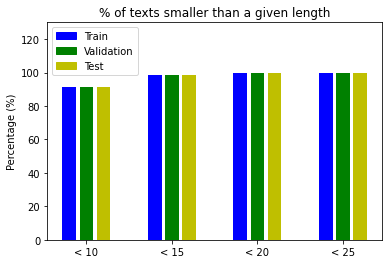

In [21]:
import matplotlib.pyplot as plt
# create dataset
bars = [91.42, 91.55, 91.32, 98.45, 98.43, 98.44, 99.49, 99.50, 99.50, 99.81, 99.81, 99.82]
labels = ['< 10', '< 15', '< 20', '< 25']

x_pos_bars = [1, 2, 3, 6, 7, 8, 11, 12, 13, 16, 17, 18]
x_pos_labels = [2, 7, 12, 17]

# Colors and mapping to values
colors = ['b', 'g', 'y']
colors_values = {'Train':'b', 'Validation':'g', 'Test': 'y'}    

labels2 = list(colors_values.keys())
handles = [plt.Rectangle((0,0),1,1, color=colors_values[label]) for label in labels2]
# Make the plot
plt.bar(x_pos_bars, bars,color = colors, label = colors_values)

# Create names on the x-axis
plt.xticks(x_pos_labels, labels)
plt.legend(handles, labels2)
plt.ylim([0, 130])
#plt.xlabel('Metrics')
plt.ylabel('Percentage (%)')
plt.title('% of texts smaller than a given length')
plt.show()

As we can see almost all news are smaller than **15** in length when tokenized so choosing this lenght to pad/truncate the tokenized news will not eliminate any information from the news in almost any case.

In [ ]:
# Pad/truncate the tokenized news

# Train
train_tokenized_pad = pad_sequences(train_tokenized, maxlen = 15, truncating = 'pre', padding = 'pre')
# Validation
valid_tokenized_pad = pad_sequences(valid_tokenized, maxlen = 15, truncating = 'pre', padding = 'pre')
# Test
test_tokenized_pad = pad_sequences(test_tokenized, maxlen = 15, truncating = 'pre', padding = 'pre')

In order to use the data with torch we have to transform the arrays into dataloader objects but first they need to be transformed into tensors.

In [ ]:
# Transform data arrays into tensors

# Train
train_tensor = torch.Tensor(train_tokenized_pad).int()
# Validation
valid_tensor = torch.Tensor(valid_tokenized_pad).int()
# Test
test_tensor =  torch.Tensor(test_tokenized_pad).int()

# Tranform tensors into data loader objects

# Train
train_set = TensorDataset(train_tensor, torch.Tensor(np.array(train_labels)))
trainloader = DataLoader(train_set, batch_size=60)
# Validation
valid_set = TensorDataset(valid_tensor, torch.Tensor(np.array(valid_labels)))
validloader = DataLoader(valid_set, batch_size=60)
# Test
test_set = TensorDataset(test_tensor, torch.Tensor(np.array(test_labels)))
testloader =  DataLoader(test_set, batch_size=60)

### Word embeddings

We will try different word embeddings and select the one which performs better. We create two functions: one to load the word embeddings and the other to create the embedding matrix.

In [ ]:
# Function to load the word embeddings

def load_embedd(filename):
    words = []
    vectors = []
    file = open(filename,'r', encoding="utf8")
    for line in file.readlines():
       row = line.split(' ')
       vocab = row[0]
       embd = row[1:len(row)]
       embd[-1] = embd[-1].rstrip()
       embd = list(map(float,embd)) # convert string to float
       words.append(vocab)
       vectors.append(embd)
    file.close()
    return words,vectors

Function to create the embedding matrix.

In [ ]:
# Function to create the embedding matrix

def embed_matx(word_index, vocab, embeddings, length_vocab, length_embedding):
    embedding_matrix = np.zeros((length_vocab +1, length_embedding))
    for word, i in word_index.items():
        if word in vocab:
            idx = vocab.index(word)
            vector =  embeddings[idx]
            embedding_matrix[i] = vector
        if i == length_vocab:
            break
    return embedding_matrix

#### Glove (300 d)

We use GloVe embeddings of dimension 300.

In [ ]:
vocab_gv_300, vectors_gv_300 = load_embedd(filename = "/content/drive/MyDrive/TFM/glove.6B.300d.txt")

Now we create the embbeding matrix.

In [ ]:
word_index = tokenizer.word_index
# Embedding matrix
embedding_matrix_gv_300 = embed_matx(word_index = word_index, vocab = vocab_gv_300, embeddings = vectors_gv_300, 
                             length_vocab = 117129, length_embedding = 300)

## Models

First we define the CNN that we will use.

In [ ]:
class CNN(nn.Module):
    def __init__(self, nlabels, train_parameters = True, random_embeddings = True): 
        super().__init__()
        
        # Embedding layer
        self.embedding = nn.Embedding(num_embeddings =117130, embedding_dim = 300)
        
        if random_embeddings == True:
            self.embedding.weight = nn.Parameter(torch.rand(117130, 300), requires_grad = train_parameters)
        else:
            self.embedding.weight = nn.Parameter(torch.from_numpy(embedding_matrix_gv_300), requires_grad = train_parameters)
            
        # Filters for the CNN    
        self.filter_sizes = [2,3,4,5]
        self.num_filters = 50
        
        # Concolutional layers
        self.convs_concat = nn.ModuleList([nn.Conv2d(1, self.num_filters, (K, 300)) for K in self.filter_sizes])
        
        # Linear layers
        self.linear1 = nn.Linear(200,128)
  
        self.linear2 = nn.Linear(128,nlabels)
    
        self.relu = nn.ReLU()
        
        self.logsoftmax = nn.LogSoftmax(dim=1) 
        
        
    def forward(self, x):
        # Embedding
        x = self.embedding(x)
        # Unsqueeze
        x = x.unsqueeze(1)
        # Convolution
        x = [F.relu(conv(x.float())).squeeze(3) for conv in self.convs_concat]
        # Max-pooling
        x = [F.max_pool1d(i, i.size(2)).squeeze(2) for i in x] 
        x = torch.cat(x, 1)
        # Linear layers
        x = self.linear1(x)
        x = self.relu(x)
        x = self.linear2(x)
        x = self.logsoftmax(x) 
        return x

In [ ]:
class CNN_extended(CNN):
    
    def __init__(self,nlabels, train_parameters, random_embeddings, epochs=100, lr=0.001):
        
        super().__init__(nlabels, train_parameters, random_embeddings)  
        
        self.lr = lr #Learning Rate
        
        self.optim = optim.Adam(self.parameters(), self.lr)
        
        self.epochs = epochs
        
        self.criterion = nn.NLLLoss()              
        
        # A list to store the loss evolution along training
        
        self.loss_during_training = [] 

        self.valid_loss_during_training = []
        
    def trainloop(self,trainloader, validloader):
        
        
        # Optimization Loop
        
        for e in range(int(self.epochs)):

            start_time = time.time()
            
            # Random data permutation at each epoch
            
            running_loss = 0.
            
            i = 0
            
            length = 0
            
            accuracies = []
            
            for news, labels in trainloader:             
        
                self.optim.zero_grad()  # Reset gradients
            
                out = self.forward(news.int())

                loss = self.criterion(out,labels.long())
                
                loss.backward()

                running_loss += loss.item()

                self.optim.step()
                
                top_p, top_class = out.topk(1, dim=1)
                
                equals = (top_class == labels.view(news.shape[0], 1))
                
                length += news.shape[0]
                
                accuracies.append(sum(equals)) 
                
                accuracy = sum(accuracies)/length
                
                i += 1
                
                if i%1000 == 0:
                    print(" Train accuracy: ", accuracy)
                
            self.loss_during_training.append(running_loss/len(trainloader))

            # Validation Loss
            
            with torch.no_grad():            
                
                running_loss = 0.
                
                i = 0
                
                length = 0
                
                accuracies = []
                
                for news,labels in validloader:
                    
                    out = self.forward(news.int())

                    loss = self.criterion(out,labels.long())

                    running_loss += loss.item()   
                    
                    top_p, top_class = out.topk(1, dim=1)
                
                    equals = (top_class == labels.view(news.shape[0], 1))
                
                    length += news.shape[0]
                
                    accuracies.append(sum(equals)) 
                
                    accuracy = sum(accuracies)/length
                    
                print(" Validation accuracy: ", accuracy)                    
                      
                self.valid_loss_during_training.append(running_loss/len(validloader))

            if(e % 1 == 0): # Every 10 epochs

                print("Training loss after %d epochs: %f" 
                      %(e,self.loss_during_training[-1]), "Validation loss after %d epochs: %f" %(e,self.valid_loss_during_training[-1]),
                      "Time per epoch: %f seconds"%(time.time() - start_time))

We train the CNN in **4** different scenarios:

  - **Random embeddings** + **Training embeddings**
  - **GloVe embeddings** + **Training embeddings**
  - **Random embeddings** + **Not training embeddings**
  - **GloVe embeddings** + **Not training embeddings**
 
We train the model for several epochs. This is done in order to select the optimal number of epochs, which occurs when the validation loss stops decreasing and starts increasing (Early Stopping). Sometimes the validation loss starts to increase after very few epochs. In those cases we stop the training prematurely since we already know the optimal number of epochs (this is what causes the "KeyboardInterrupt" message in some of the results which can be seen below).

### Random embeddings  + Training embeddings

In [ ]:
# Initialize model
CNN_train_random = CNN_extended(nlabels = 6, epochs=5, lr=0.003, train_parameters = True, random_embeddings = True)
# Train model
CNN_train_random.trainloop(trainloader, validloader)

 Train accuracy:  tensor([0.5957])
 Train accuracy:  tensor([0.6299])
 Train accuracy:  tensor([0.6476])
 Train accuracy:  tensor([0.6581])
 Train accuracy:  tensor([0.6661])
 Train accuracy:  tensor([0.6726])
 Train accuracy:  tensor([0.6772])
 Train accuracy:  tensor([0.6813])
 Train accuracy:  tensor([0.6849])
 Validation accuracy:  tensor([0.7139])
Training loss after 0 epochs: 0.881487 Validation loss after 0 epochs: 0.812628 Time per epoch: 6060.227753 seconds
 Train accuracy:  tensor([0.7296])
 Train accuracy:  tensor([0.7350])
 Train accuracy:  tensor([0.7385])
 Train accuracy:  tensor([0.7408])
 Train accuracy:  tensor([0.7430])
 Train accuracy:  tensor([0.7449])
 Train accuracy:  tensor([0.7463])
 Train accuracy:  tensor([0.7477])
 Train accuracy:  tensor([0.7493])
 Validation accuracy:  tensor([0.7138])
Training loss after 1 epochs: 0.711673 Validation loss after 1 epochs: 0.837501 Time per epoch: 7207.740807 seconds
 Train accuracy:  tensor([0.7730])
 Train accuracy:  tenso

KeyboardInterrupt: ignored

### GloVe embeddings  + Training embeddings

In [ ]:
# Initialize model
CNN_train_not_random = CNN_extended(nlabels = 6, epochs=4, lr=0.003, train_parameters = True, random_embeddings = False)
# Train model
CNN_train_not_random.trainloop(trainloader, validloader)

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:652: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool1d(input, kernel_size, stride, padding, dilation, ceil_mode)


 Train accuracy:  tensor([0.6674])
 Train accuracy:  tensor([0.6835])
 Train accuracy:  tensor([0.6923])
 Train accuracy:  tensor([0.6978])
 Train accuracy:  tensor([0.7029])
 Train accuracy:  tensor([0.7071])
 Train accuracy:  tensor([0.7100])
 Train accuracy:  tensor([0.7125])
 Train accuracy:  tensor([0.7149])
 Validation accuracy:  tensor([0.7311])
Training loss after 0 epochs: 0.805835 Validation loss after 0 epochs: 0.765596 Time per epoch: 9030.680334 seconds
 Train accuracy:  tensor([0.7588])
 Train accuracy:  tensor([0.7662])
 Train accuracy:  tensor([0.7695])
 Train accuracy:  tensor([0.7721])
 Train accuracy:  tensor([0.7750])
 Train accuracy:  tensor([0.7773])
 Train accuracy:  tensor([0.7789])
 Train accuracy:  tensor([0.7803])
 Train accuracy:  tensor([0.7818])
 Validation accuracy:  tensor([0.7244])
Training loss after 1 epochs: 0.623853 Validation loss after 1 epochs: 0.826593 Time per epoch: 10139.675975 seconds
 Train accuracy:  tensor([0.8123])
 Train accuracy:  tens

KeyboardInterrupt: ignored

### Random embeddings  + Not training embeddings

In [ ]:
# Initialize model
CNN_not_train_random = CNN_extended(nlabels = 6, epochs=9, lr=0.003, train_parameters = False, random_embeddings = True)
# Train model
CNN_not_train_random.trainloop(trainloader, validloader)

 Train accuracy:  tensor([0.5501])
 Train accuracy:  tensor([0.5608])
 Train accuracy:  tensor([0.5671])
 Train accuracy:  tensor([0.5729])
 Train accuracy:  tensor([0.5778])
 Train accuracy:  tensor([0.5820])
 Train accuracy:  tensor([0.5851])
 Train accuracy:  tensor([0.5879])
 Train accuracy:  tensor([0.5903])
 Validation accuracy:  tensor([0.6015])
Training loss after 0 epochs: 1.121780 Validation loss after 0 epochs: 1.108112 Time per epoch: 635.669165 seconds
 Train accuracy:  tensor([0.6119])
 Train accuracy:  tensor([0.6135])
 Train accuracy:  tensor([0.6132])
 Train accuracy:  tensor([0.6132])
 Train accuracy:  tensor([0.6138])
 Train accuracy:  tensor([0.6145])
 Train accuracy:  tensor([0.6152])
 Train accuracy:  tensor([0.6157])
 Train accuracy:  tensor([0.6164])
 Validation accuracy:  tensor([0.6112])
Training loss after 1 epochs: 1.062122 Validation loss after 1 epochs: 1.081675 Time per epoch: 637.249443 seconds
 Train accuracy:  tensor([0.6229])
 Train accuracy:  tensor(

### GloVe embeddings  + Not training embeddings

In [ ]:
# Initialize model
CNN_not_train_not_random = CNN_extended(nlabels = 6, epochs=9, lr=0.003, train_parameters = False, random_embeddings = False)
# Train model
CNN_not_train_not_random.trainloop(trainloader, validloader)

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:652: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool1d(input, kernel_size, stride, padding, dilation, ceil_mode)


 Train accuracy:  tensor([0.6494])
 Train accuracy:  tensor([0.6620])
 Train accuracy:  tensor([0.6693])
 Train accuracy:  tensor([0.6744])
 Train accuracy:  tensor([0.6784])
 Train accuracy:  tensor([0.6814])
 Train accuracy:  tensor([0.6839])
 Train accuracy:  tensor([0.6862])
 Train accuracy:  tensor([0.6880])
 Validation accuracy:  tensor([0.7028])
Training loss after 0 epochs: 0.875074 Validation loss after 0 epochs: 0.833539 Time per epoch: 662.245848 seconds
 Train accuracy:  tensor([0.7074])
 Train accuracy:  tensor([0.7092])
 Train accuracy:  tensor([0.7107])
 Train accuracy:  tensor([0.7116])
 Train accuracy:  tensor([0.7131])
 Train accuracy:  tensor([0.7139])
 Train accuracy:  tensor([0.7148])
 Train accuracy:  tensor([0.7158])
 Train accuracy:  tensor([0.7167])
 Validation accuracy:  tensor([0.7108])
Training loss after 1 epochs: 0.798680 Validation loss after 1 epochs: 0.823584 Time per epoch: 656.923089 seconds
 Train accuracy:  tensor([0.7263])
 Train accuracy:  tensor(

## Testing performance

We join the **train** and **validation** datasets and we train the model with this dataset using the optimal number of epochs. Then we evaluate the model with the **test** set. First we need to modify a bit the class used previously.

In [ ]:
class CNN_extended(CNN):
    
    def __init__(self,nlabels, train_parameters, random_embeddings, epochs=100,lr=0.001):
        
        super().__init__(nlabels, train_parameters, random_embeddings)  
        
        self.lr = lr #Learning Rate
        
        self.optim = optim.Adam(self.parameters(), self.lr)
        
        self.epochs = epochs
        
        self.criterion = nn.NLLLoss()               
        
        # A list to store the loss evolution along training
        
        self.loss_during_training = [] 

        self.valid_loss_during_training = []
        
    def trainloop(self,trainloader):
        
        
        # Optimization Loop
        
        for e in range(int(self.epochs)):

            start_time = time.time()
            
            # Random data permutation at each epoch
            
            running_loss = 0.
            
            i = 0
            
            length = 0
            
            accuracies = []
            
            for news, labels in trainloader:             
        
                self.optim.zero_grad()  # Reset gradients
            
                out = self.forward(news.int())

                loss = self.criterion(out,labels.long())
                
                loss.backward()

                running_loss += loss.item()

                self.optim.step()
                
                top_p, top_class = out.topk(1, dim=1)
                
                equals = (top_class == labels.view(news.shape[0], 1))
                
                length += news.shape[0]
                
                accuracies.append(sum(equals)) 
                
                accuracy = sum(accuracies)/length
                
                i += 1
                
                if i%1000 == 0:
                    print(" Train accuracy: ", accuracy)
                
            self.loss_during_training.append(running_loss/len(trainloader))
            end_time = time.time()
            print("Elapsed time: ", end_time-start_time)

                
    def eval_performance(self,dataloader):
        predictions = np.empty((1,1))

        with torch.no_grad():

            for news,labels in dataloader:
                
                logprobs = self.forward(news)  
                top_p, top_class = logprobs.topk(1, dim=1)
                
                top_class_array = np.array(top_class)
                predictions = np.concatenate((predictions, top_class_array), axis = 0)
                
        return predictions[1:]

Now we join the train and validation sets.

In [ ]:
# Join train and validation sequences
train_valid_tokenized_pad = np.concatenate((train_tokenized_pad, valid_tokenized_pad), axis = 0)
# Join train and validation labels
train_valid_labels = np.concatenate((np.array(train_labels), np.array(valid_labels)), axis = 0)

# Create tensor objects

# Train + validation
train_valid_tensor = torch.Tensor(train_valid_tokenized_pad).int()
# Test
test_tensor =  torch.Tensor(test_tokenized_pad).int()

# Tranform tensors into data loader objects

# Train + validation
train_valid_set = TensorDataset(train_valid_tensor, torch.Tensor(np.array(train_valid_labels)))
train_valid_loader = DataLoader(train_valid_set, batch_size=60)
# Test
test_set = TensorDataset(test_tensor, torch.Tensor(np.array(test_labels)))
testloader =  DataLoader(test_set, batch_size=60)

### Random embeddings  + Training embeddings

In [ ]:
# Initialize model
CNN_test_train_random = CNN_extended(nlabels = 6, epochs=1, lr=0.003, train_parameters = True, random_embeddings = True)
# Train model
CNN_test_train_random.trainloop(train_valid_loader)
# Get predictions
predictions1 = CNN_test_train_random.eval_performance(testloader)

 Train accuracy:  tensor([0.5919])
 Train accuracy:  tensor([0.6198])
 Train accuracy:  tensor([0.6408])
 Train accuracy:  tensor([0.6534])
 Train accuracy:  tensor([0.6628])
 Train accuracy:  tensor([0.6697])
 Train accuracy:  tensor([0.6752])
 Train accuracy:  tensor([0.6800])
 Train accuracy:  tensor([0.6841])
 Train accuracy:  tensor([0.6874])
Elapsed time:  7168.229678869247


In [ ]:
print(classification_report(np.array(test_labels).reshape(len(test_labels),1), predictions1))

              precision    recall  f1-score   support

           0       0.71      0.87      0.79     23507
           1       0.63      0.26      0.37      3514
           2       0.70      0.48      0.57     11297
           3       0.72      0.07      0.13      1224
           4       0.75      0.84      0.79     17472
           5       0.71      0.54      0.61      2305

    accuracy                           0.72     59319
   macro avg       0.70      0.51      0.54     59319
weighted avg       0.72      0.72      0.70     59319



In [ ]:
# Classification report without 'true' label
print(classification_report(np.array(test_labels).reshape(len(test_labels),1), predictions1, labels = [1,2,3,4,5]))

              precision    recall  f1-score   support

           1       0.63      0.26      0.37      3514
           2       0.70      0.48      0.57     11297
           3       0.72      0.07      0.13      1224
           4       0.75      0.84      0.79     17472
           5       0.71      0.54      0.61      2305

   micro avg       0.73      0.62      0.67     35812
   macro avg       0.70      0.44      0.49     35812
weighted avg       0.72      0.62      0.65     35812



In [ ]:
# Confusion matrix
print(confusion_matrix(np.array(test_labels).reshape(len(test_labels),1), predictions1))

[[20543   198  1057    12  1512   185]
 [ 1439   923   206     5   885    56]
 [ 3499   109  5391     7  2113   178]
 [  796    55    87    85   170    31]
 [ 1803   139   791     5 14672    62]
 [  706    51   131     4   172  1241]]


### GloVe embeddings  + Training embeddings

In [ ]:
# Initialize model
CNN_test_train_not_random = CNN_extended(nlabels = 6, epochs=1, lr=0.003, train_parameters = True, random_embeddings = False)
# Train model
CNN_test_train_not_random.trainloop(train_valid_loader)
# Get predictions
predictions_2 = CNN_test_train_not_random.eval_performance(testloader)

 Train accuracy:  tensor([0.6673])
 Train accuracy:  tensor([0.6831])
 Train accuracy:  tensor([0.6921])
 Train accuracy:  tensor([0.6976])
 Train accuracy:  tensor([0.7028])
 Train accuracy:  tensor([0.7066])
 Train accuracy:  tensor([0.7096])
 Train accuracy:  tensor([0.7120])
 Train accuracy:  tensor([0.7144])
 Train accuracy:  tensor([0.7164])
Elapsed time:  9102.66008424759


In [ ]:
print(classification_report(np.array(test_labels).reshape(len(test_labels),1), predictions_2))

              precision    recall  f1-score   support

           0       0.74      0.87      0.80     23507
           1       0.67      0.35      0.46      3514
           2       0.71      0.54      0.61     11297
           3       0.70      0.11      0.19      1224
           4       0.76      0.83      0.80     17472
           5       0.74      0.58      0.65      2305

    accuracy                           0.74     59319
   macro avg       0.72      0.55      0.58     59319
weighted avg       0.73      0.74      0.72     59319



In [ ]:
# Classification report without 'true' label
print(classification_report(np.array(test_labels).reshape(len(test_labels),1), predictions_2, labels = [1,2,3,4,5]))

              precision    recall  f1-score   support

           1       0.67      0.35      0.46      3514
           2       0.71      0.54      0.61     11297
           3       0.70      0.11      0.19      1224
           4       0.76      0.83      0.80     17472
           5       0.74      0.58      0.65      2305

   micro avg       0.74      0.65      0.69     35812
   macro avg       0.71      0.48      0.54     35812
weighted avg       0.73      0.65      0.67     35812



In [ ]:
# Confusion matrix
print(confusion_matrix(np.array(test_labels).reshape(len(test_labels),1), predictions_2))

[[20466   212  1159    33  1474   163]
 [ 1278  1223   147     6   806    54]
 [ 3044   131  6078    13  1862   169]
 [  738    44    94   131   188    29]
 [ 1679   181  1010     4 14541    57]
 [  633    45    93     1   192  1341]]


### Random embeddings  +  Not training embeddings

In [ ]:
# Initialize model
CNN_test_not_train_random = CNN_extended(nlabels = 6, epochs=9, lr=0.003, train_parameters = False, random_embeddings = True)
# Train model
CNN_test_not_train_random.trainloop(train_valid_loader)
# Get predictions
predictions_3 = CNN_test_not_train_random.eval_performance(testloader)

 Train accuracy:  tensor([0.5530])
 Train accuracy:  tensor([0.5597])
 Train accuracy:  tensor([0.5638])
 Train accuracy:  tensor([0.5688])
 Train accuracy:  tensor([0.5730])
 Train accuracy:  tensor([0.5763])
 Train accuracy:  tensor([0.5796])
 Train accuracy:  tensor([0.5827])
 Train accuracy:  tensor([0.5856])
 Train accuracy:  tensor([0.5880])
Elapsed time:  743.8465197086334
 Train accuracy:  tensor([0.6123])
 Train accuracy:  tensor([0.6118])
 Train accuracy:  tensor([0.6123])
 Train accuracy:  tensor([0.6127])
 Train accuracy:  tensor([0.6134])
 Train accuracy:  tensor([0.6141])
 Train accuracy:  tensor([0.6147])
 Train accuracy:  tensor([0.6150])
 Train accuracy:  tensor([0.6156])
 Train accuracy:  tensor([0.6159])
Elapsed time:  741.4050281047821
 Train accuracy:  tensor([0.6202])
 Train accuracy:  tensor([0.6200])
 Train accuracy:  tensor([0.6203])
 Train accuracy:  tensor([0.6208])
 Train accuracy:  tensor([0.6211])
 Train accuracy:  tensor([0.6217])
 Train accuracy:  tensor

In [ ]:
print(classification_report(np.array(test_labels).reshape(len(test_labels),1), predictions_3))

              precision    recall  f1-score   support

           0       0.63      0.81      0.71     23507
           1       0.81      0.03      0.06      3514
           2       0.52      0.34      0.41     11297
           3       0.30      0.02      0.04      1224
           4       0.67      0.78      0.72     17472
           5       0.69      0.29      0.41      2305

    accuracy                           0.63     59319
   macro avg       0.60      0.38      0.39     59319
weighted avg       0.63      0.63      0.59     59319



In [ ]:
# Classification report without 'true' label
print(classification_report(np.array(test_labels).reshape(len(test_labels),1), predictions_3, labels = [1,2,3,4,5]))

              precision    recall  f1-score   support

           1       0.81      0.03      0.06      3514
           2       0.52      0.34      0.41     11297
           3       0.30      0.02      0.04      1224
           4       0.67      0.78      0.72     17472
           5       0.69      0.29      0.41      2305

   micro avg       0.63      0.51      0.56     35812
   macro avg       0.60      0.29      0.33     35812
weighted avg       0.62      0.51      0.51     35812



In [ ]:
# Confusion matrix
print(confusion_matrix(np.array(test_labels).reshape(len(test_labels),1), predictions_3))

[[19038    13  1838    22  2467   129]
 [ 2119   112   288     8   953    34]
 [ 4362     5  3845     3  2992    90]
 [  904     0   123    29   150    18]
 [ 2792     7   974    24 13640    35]
 [ 1093     2   307    11   221   671]]


### GloVe embeddings  +  Not training embeddings

In [ ]:
# Initialize model
CNN_test_not_train_not_random = CNN_extended(nlabels = 6, epochs=2, lr=0.003, train_parameters = False, random_embeddings = False)
# Train model
CNN_test_not_train_not_random.trainloop(train_valid_loader)
# Get predictions
predictions_4 = CNN_test_not_train_not_random.eval_performance(testloader)

 Train accuracy:  tensor([0.7470])
 Train accuracy:  tensor([0.7592])
 Train accuracy:  tensor([0.7651])
 Train accuracy:  tensor([0.7689])
 Train accuracy:  tensor([0.7726])
 Train accuracy:  tensor([0.7754])
 Train accuracy:  tensor([0.7776])
 Train accuracy:  tensor([0.7800])
 Train accuracy:  tensor([0.7822])
 Train accuracy:  tensor([0.7846])
Elapsed time:  740.8222987651825
 Train accuracy:  tensor([0.7633])
 Train accuracy:  tensor([0.7730])
 Train accuracy:  tensor([0.7778])
 Train accuracy:  tensor([0.7817])
 Train accuracy:  tensor([0.7854])
 Train accuracy:  tensor([0.7881])
 Train accuracy:  tensor([0.7905])
 Train accuracy:  tensor([0.7925])
 Train accuracy:  tensor([0.7948])
 Train accuracy:  tensor([0.7971])
Elapsed time:  733.8853116035461


In [ ]:
print(classification_report(np.array(test_labels).reshape(len(test_labels),1), predictions_4))

              precision    recall  f1-score   support

           0       0.76      0.81      0.79     23507
           1       0.60      0.40      0.48      3514
           2       0.65      0.59      0.62     11297
           3       0.35      0.21      0.26      1224
           4       0.75      0.82      0.79     17472
           5       0.71      0.59      0.64      2305

    accuracy                           0.73     59319
   macro avg       0.64      0.57      0.60     59319
weighted avg       0.72      0.73      0.72     59319



In [ ]:
# Classification report without 'true' label
print(classification_report(np.array(test_labels).reshape(len(test_labels),1), predictions_4, labels = [1,2,3,4,5]))

              precision    recall  f1-score   support

           1       0.60      0.40      0.48      3514
           2       0.65      0.59      0.62     11297
           3       0.35      0.21      0.26      1224
           4       0.75      0.82      0.79     17472
           5       0.71      0.59      0.64      2305

   micro avg       0.70      0.67      0.69     35812
   macro avg       0.61      0.52      0.56     35812
weighted avg       0.69      0.67      0.68     35812



In [ ]:
# Confusion matrix
print(confusion_matrix(np.array(test_labels).reshape(len(test_labels),1), predictions_4))

[[19078   369  1802   269  1765   224]
 [  998  1414   249    49   736    68]
 [ 2396   181  6675    72  1812   161]
 [  582    62   128   253   172    27]
 [ 1451   298  1291    44 14318    70]
 [  550    49   122    43   188  1353]]
